In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.cm as cm
from matplotlib import pyplot as plt
from scipy import stats as st
import seaborn as sns

from IPython.core.pylabtools import figsize

import numpy.random as r
from pylab import *
from matplotlib.gridspec import GridSpec

import sys
sys.path.insert(0, '../../utils')
import splicing_utils as spu
import single_cell_plots as scp
from single_cell_plots import *

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["axes.facecolor"] = 'white'

import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
data_dir = '/mnt/c/Users/ferna/Desktop/SingleCell/data/' # adjust to the proper directory
%run -i '../../utils/load_data.py'

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore
from random import sample
from scipy.special import logit

from scipy.stats import pearsonr
from scipy.stats import spearmanr
def test_pearson(x, y):
    x_t = x.loc[x.dropna().index].index
    y_t = y.loc[y.dropna().index].index
    
    common = [z for z in x_t if z in y_t]
    
    return pearsonr(x.loc[common], y.loc[common])

In [4]:
kinetics_C57 = pd.read_csv(data_dir + 'kinetics/mES_kinetics_C57.csv', index_col=0)
kinetics_C57 = kinetics_C57.loc[~kinetics_C57.index.duplicated(keep='first')]
kinetics_CAST = pd.read_csv(data_dir + 'kinetics/mES_kinetics_CAST.csv', index_col=0)
kinetics_CAST = kinetics_CAST.loc[~kinetics_CAST.index.duplicated(keep='first')]

C57_mle_name = kinetics_C57.columns[0]
C57_freq_name = kinetics_C57.columns[1]
C57_size_name = kinetics_C57.columns[2]

CAST_mle_name = kinetics_CAST.columns[0]
CAST_freq_name = kinetics_CAST.columns[1]
CAST_size_name = kinetics_CAST.columns[2]


C57_freq = []
C57_size = []
for i in kinetics_C57.index:
    
    kon = kinetics_C57.loc[i, C57_mle_name][1:].split()[0]
    koff = kinetics_C57.loc[i, C57_mle_name][1:].split()[1]
    ksyn = kinetics_C57.loc[i, C57_mle_name][1:].split()[2][:-1]
    
    if kon[-1] == ',':
        print(kon)
        kon = kon[:-1]
    if koff[-1] == ',':
        print(koff)
        koff = koff[:-1]
    if ksyn[-1] == ',':
        print(ksyn)
        ksyn = ksyn[:-1]
    
    C57_freq.append(float(kon))
    C57_size.append(float(ksyn)/float(koff))
    
    
CAST_freq = []
CAST_size = []
    
for i in kinetics_CAST.index:
    
    CAST_freq.append(float(kinetics_CAST.loc[i, C57_mle_name][1:].split()[0]))
    
    koff = float(kinetics_CAST.loc[i, CAST_mle_name][1:].split()[1])
    ksyn = float(kinetics_CAST.loc[i, CAST_mle_name][1:].split()[2][:-1])
    
    CAST_size.append(ksyn/koff)
        

C57_kinetics = pd.DataFrame()
C57_kinetics['gene'] = kinetics_C57.index
C57_kinetics['C57_frequency'] = C57_freq
C57_kinetics['C57_size'] = C57_size
C57_kinetics = C57_kinetics.set_index('gene')

CAST_kinetics = pd.DataFrame()
CAST_kinetics['gene'] = kinetics_CAST.index
CAST_kinetics['CAST_frequency'] = CAST_freq
CAST_kinetics['CAST_size'] = CAST_size
CAST_kinetics = CAST_kinetics.set_index('gene')
kinetic_table = pd.concat([CAST_kinetics, C57_kinetics], axis=1)

chen_int_genes, chen_int_exons = spu.get_int_events(chen_PSI[chen_ES2i], chen_mrna_counts[chen_ES2i], min_unimodal = 0.2)

size_list = []
frequency_list = []
psi_binary = []
exon_lista = []
psi_std = []
psi_mean = []
for i in chen_int_exons:
    if i.split('_')[0] in kinetic_table.index:
        exon_lista.append(i)
        size_list.append(kinetic_table.loc[i.split('_')[0], ['C57_size', 'CAST_size']].mean())
        frequency_list.append(kinetic_table.loc[i.split('_')[0], ['C57_frequency', 'CAST_frequency']].mean())
        psi_binary.append((np.abs(0.5 - chen_PSI[chen_ES2i].loc[i]) >= 0.45).sum() / np.sum(~chen_PSI[chen_ES2i].loc[i].isna()))
        psi_std.append(chen_PSI[chen_ES2i].loc[i].std())
        psi_mean.append(chen_PSI[chen_ES2i].loc[i].mean())
        
        
burst_psi = pd.DataFrame()
burst_psi['exon'] = exon_lista
burst_psi['frequency'] = frequency_list
burst_psi['size'] = size_list
burst_psi['psi_std'] = psi_std
burst_psi['psi_mean'] = psi_mean
burst_psi['psi_binary'] = psi_binary
burst_psi = burst_psi.set_index('exon')

1.85595906,
47.25645625,


In [5]:
def test_burst(PSI_tab, mrna_counts, mrna_per_event, read_counts, subpop, kinetic_table,  min_unimodal = 0.2):

    int_genes, int_exons = spu.get_int_events(PSI_tab[subpop], mrna_counts[subpop], min_unimodal = min_unimodal)

    size_list = []
    frequency_list = []
    psi_binary = []
    exon_lista = []
    psi_std = []
    psi_mean = []
    for i in int_exons:
        if i.split('_')[0] in kinetic_table.index:
            exon_lista.append(i)
            size_list.append(kinetic_table.loc[i.split('_')[0], ['C57_size', 'CAST_size']].mean())
            frequency_list.append(kinetic_table.loc[i.split('_')[0], ['C57_frequency', 'CAST_frequency']].mean())
            psi_binary.append((np.abs(0.5 - PSI_tab[subpop].loc[i]) >= 0.45).sum() / np.sum(~PSI_tab[subpop].loc[i].isna()))
            psi_std.append(PSI_tab[subpop].loc[i].std())
            psi_mean.append(PSI_tab[subpop].loc[i].mean())
        

    burst_psi = pd.DataFrame()
    burst_psi['exon'] = exon_lista
    burst_psi['frequency'] = np.log10(np.array(frequency_list)+1)
    burst_psi['size'] = np.log10(np.array(size_list)+1)
    burst_psi['psi_std'] = psi_std
    burst_psi['psi_mean'] = np.abs(0.5 - np.array(psi_mean))
    burst_psi['psi_binary'] = psi_binary
    burst_psi = burst_psi.set_index('exon')

    burst_expression =  mrna_per_event.loc[burst_psi.index, subpop].mean(axis=1)
    reads =  read_counts.loc[burst_psi.index, subpop].mean(axis=1)
    burst_psi['mean_expression'] = np.log10(burst_expression+1)
    burst_psi['read_counts'] = np.log10(reads+1)
    
    low_exp = burst_expression.index[burst_expression <= burst_expression.quantile(0.25)]
    med_exp = burst_expression.index[(burst_expression > burst_expression.quantile(0.25)) & ((burst_expression <= burst_expression.quantile(0.5)))]
    med_high_exp = burst_expression.index[(burst_expression > burst_expression.quantile(0.5)) & ((burst_expression <= burst_expression.quantile(0.75)))]
    high_exp = burst_expression.index[burst_expression > burst_expression.quantile(0.75)]
    
    freq_cor_bin = []
    freq_cor_std = []
    
    size_cor_bin = []
    size_cor_std = []
    
    freq_cor_bin.append(test_pearson(np.log10(burst_psi.loc[low_exp, 'frequency']+1), burst_psi.loc[low_exp, 'psi_binary']))
    freq_cor_bin.append(test_pearson(np.log10(burst_psi.loc[med_exp, 'frequency']+1), burst_psi.loc[med_exp, 'psi_binary']))
    freq_cor_bin.append(test_pearson(np.log10(burst_psi.loc[med_high_exp, 'frequency']+1), burst_psi.loc[med_high_exp, 'psi_binary']))
    freq_cor_bin.append(test_pearson(np.log10(burst_psi.loc[high_exp, 'frequency']+1), burst_psi.loc[high_exp, 'psi_binary']))
    
    freq_cor_std.append(test_pearson(np.log10(burst_psi.loc[low_exp, 'frequency']+1), burst_psi.loc[low_exp, 'psi_std']))
    freq_cor_std.append(test_pearson(np.log10(burst_psi.loc[med_exp, 'frequency']+1), burst_psi.loc[med_exp, 'psi_std']))
    freq_cor_std.append(test_pearson(np.log10(burst_psi.loc[med_high_exp, 'frequency']+1), burst_psi.loc[med_high_exp, 'psi_std']))
    freq_cor_std.append(test_pearson(np.log10(burst_psi.loc[high_exp, 'frequency']+1), burst_psi.loc[high_exp, 'psi_std']))
    
    size_cor_bin.append(test_pearson(np.log10(burst_psi.loc[low_exp, 'size']+1), burst_psi.loc[low_exp, 'psi_binary']))
    size_cor_bin.append(test_pearson(np.log10(burst_psi.loc[med_exp, 'size']+1), burst_psi.loc[med_exp, 'psi_binary']))
    size_cor_bin.append(test_pearson(np.log10(burst_psi.loc[med_high_exp, 'size']+1), burst_psi.loc[med_high_exp, 'psi_binary']))
    size_cor_bin.append(test_pearson(np.log10(burst_psi.loc[high_exp, 'size']+1), burst_psi.loc[high_exp, 'psi_binary']))
    
    size_cor_std.append(test_pearson(np.log10(burst_psi.loc[low_exp, 'size']+1), burst_psi.loc[low_exp, 'psi_std']))
    size_cor_std.append(test_pearson(np.log10(burst_psi.loc[med_exp, 'size']+1), burst_psi.loc[med_exp, 'psi_std']))
    size_cor_std.append(test_pearson(np.log10(burst_psi.loc[med_high_exp, 'size']+1), burst_psi.loc[med_high_exp, 'psi_std']))
    size_cor_std.append(test_pearson(np.log10(burst_psi.loc[high_exp, 'size']+1), burst_psi.loc[high_exp, 'psi_std']))
    
    return freq_cor_bin, freq_cor_std, size_cor_bin, size_cor_std, burst_psi, low_exp, med_exp, med_high_exp, high_exp


In [6]:
ES2i_kinetics = test_burst(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts,
                           list(chen_ES2i), kinetic_table,  min_unimodal = 0.2)


In [7]:
# ES2i_kinetics = test_burst(chen_PSI, chen_mrna_counts, chen_read_counts, 
#                            list(chen_ES2i), kinetic_table,  min_unimodal = 0.2)


In [8]:
burst_psi_ES2i = ES2i_kinetics[4]
low_exp = ES2i_kinetics[5]
med_exp = ES2i_kinetics[6]
med_high_exp = ES2i_kinetics[7]
high_exp = ES2i_kinetics[8]

q75 = burst_psi_ES2i.mean_expression.quantile(0.05)
q95 = burst_psi_ES2i.mean_expression.quantile(0.95)
burst_psi_selected = burst_psi_ES2i.loc[(burst_psi_ES2i.mean_expression >= q75) & (burst_psi_ES2i.mean_expression <= q95)]
psi_corrected = []
for x in burst_psi_selected.psi_binary:
    if x <= 0.01:
        psi_corrected.append(0.01)
    elif x >= 0.99:
        psi_corrected.append(expit(4))
    else:
        psi_corrected.append(x)
        
burst_psi_selected['psi_corrected'] = list(logit(np.array(psi_corrected)))


../../utils/load_data.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import single_cell_plots as scp


In [83]:
.168**2

0.028224000000000003

In [9]:
from sklearn.metrics import r2_score

In [85]:
pearsonr(burst_psi_selected['size'], burst_psi_selected['mean_expression'])

(0.19783339634758337, 4.054651919196297e-08)

In [10]:
burst_psi_ES2i = ES2i_kinetics[4]
low_exp = ES2i_kinetics[5]
med_exp = ES2i_kinetics[6]
med_high_exp = ES2i_kinetics[7]
high_exp = ES2i_kinetics[8]

q75 = burst_psi_ES2i.mean_expression.quantile(0.05)
q95 = burst_psi_ES2i.mean_expression.quantile(0.95)
burst_psi_selected = burst_psi_ES2i.loc[(burst_psi_ES2i.mean_expression >= q75) & (burst_psi_ES2i.mean_expression <= q95)]


select = burst_psi_selected.index[(burst_psi_selected.psi_binary > 0.001) & ( burst_psi_selected.psi_binary < 0.999)]
burst_psi_selected = burst_psi_selected.loc[select]


burst_psi_selected['psi_corrected'] = list(logit(np.array(burst_psi_selected.psi_binary)))
# burst_psi_selected.loc[train, 'psi_corrected']

# train = sample(list(burst_psi_selected.index), int(burst_psi_selected.shape[0]*0.8))
# test = [x for x in burst_psi_selected.index if x not in train]


<Figure size 432x432 with 0 Axes>

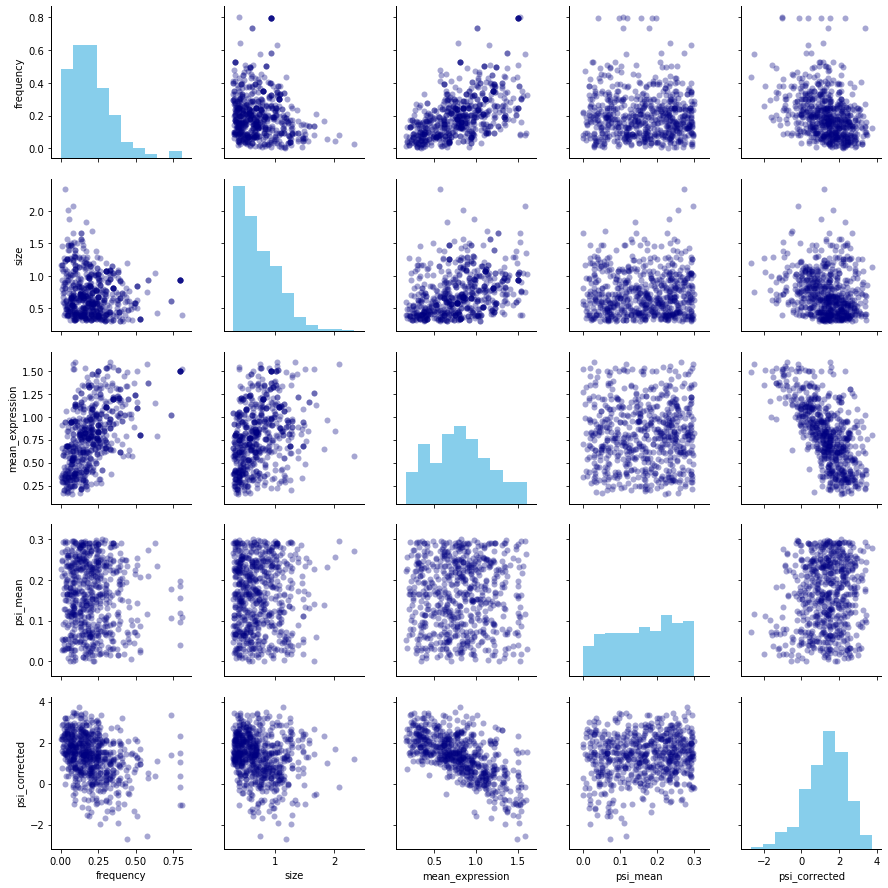

In [11]:
figsize(6, 6)
plt.figure()
g = sns.PairGrid(burst_psi_selected[['frequency', 'size', 'mean_expression', 'psi_mean', 'psi_corrected']])
g.map_upper(plt.scatter,color='navy', alpha=0.35, linewidth=0)
g.map_lower(plt.scatter, color='navy', alpha=0.35, linewidth=0)
g.map_diag(plt.hist, color='skyblue')
# plt.savefig('plots_review/figure1/kinetics/pairplot_mrna.pdf', bbox_inches='tight', transparent=True)
# plt.savefig('plots_review/figure1/kinetics/pairplot_mrna.png', dpi=300, bbox_inches='tight', transparent=True)

In [14]:
burst_psi_df = burst_psi_selected[['frequency', 'size', 'mean_expression', 'read_counts', 'psi_mean',  'psi_corrected']]
burst_psi_df.columns = ['frequency', 'size', 'mean_expression', 'read_counts', 'psi_mean', 'psi_binary']
burst_psi_df.to_csv('burst_psi_kinetics_LR.tab', sep='\t', index=True, header=True)

In [13]:
burst_psi_df.shape

(619, 5)

<Figure size 432x432 with 0 Axes>

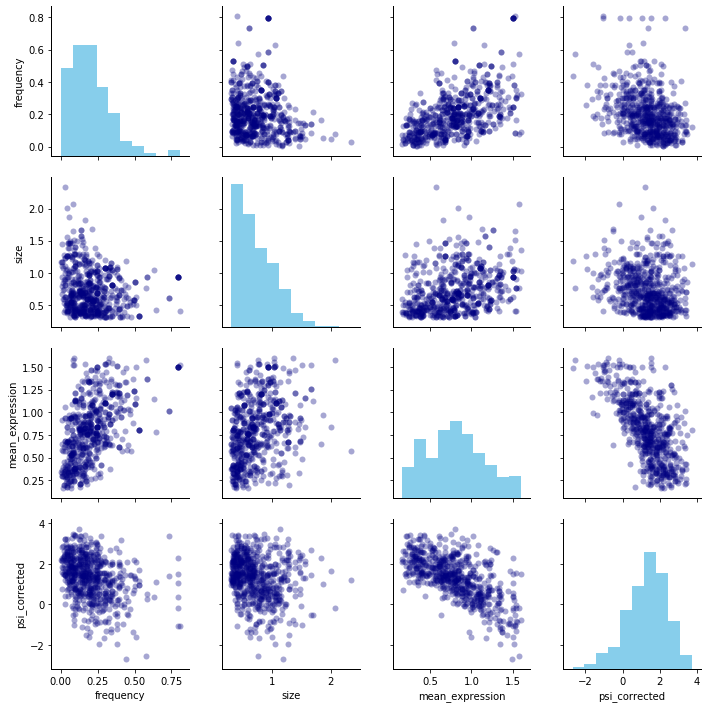

In [109]:
figsize(6, 6)
plt.figure()
g = sns.PairGrid(burst_psi_selected[['frequency', 'size', 'mean_expression', 'psi_corrected']])
g.map_upper(plt.scatter,color='navy', alpha=0.35, linewidth=0)
g.map_lower(plt.scatter, color='navy', alpha=0.35, linewidth=0)
g.map_diag(plt.hist, color='skyblue')
plt.savefig('plots_review/figure1/kinetics/pairplot_mrna.pdf', bbox_inches='tight', transparent=True)
plt.savefig('plots_review/figure1/kinetics/pairplot_mrna.png', dpi=300, bbox_inches='tight', transparent=True)

<Figure size 432x432 with 0 Axes>

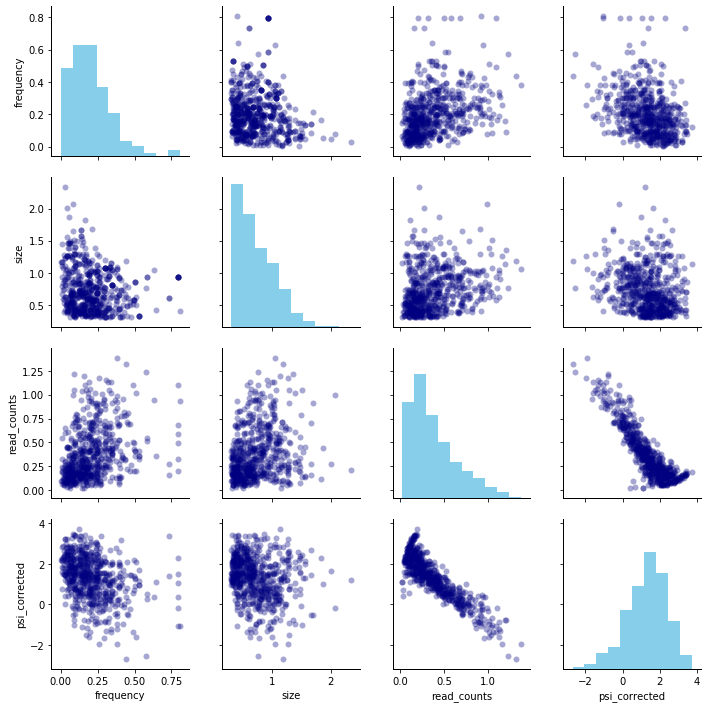

In [110]:
figsize(6, 6)
plt.figure()
g = sns.PairGrid(burst_psi_selected[['frequency', 'size', 'read_counts', 'psi_corrected']])
g.map_upper(plt.scatter,color='navy', alpha=0.35, linewidth=0)
g.map_lower(plt.scatter, color='navy', alpha=0.35, linewidth=0)
g.map_diag(plt.hist, color='skyblue')
plt.savefig('plots_review/figure1/kinetics/pairplot_reads.pdf', bbox_inches='tight', transparent=True)
plt.savefig('plots_review/figure1/kinetics/pairplot_reads.png', dpi=300, bbox_inches='tight', transparent=True)

<Figure size 432x432 with 0 Axes>

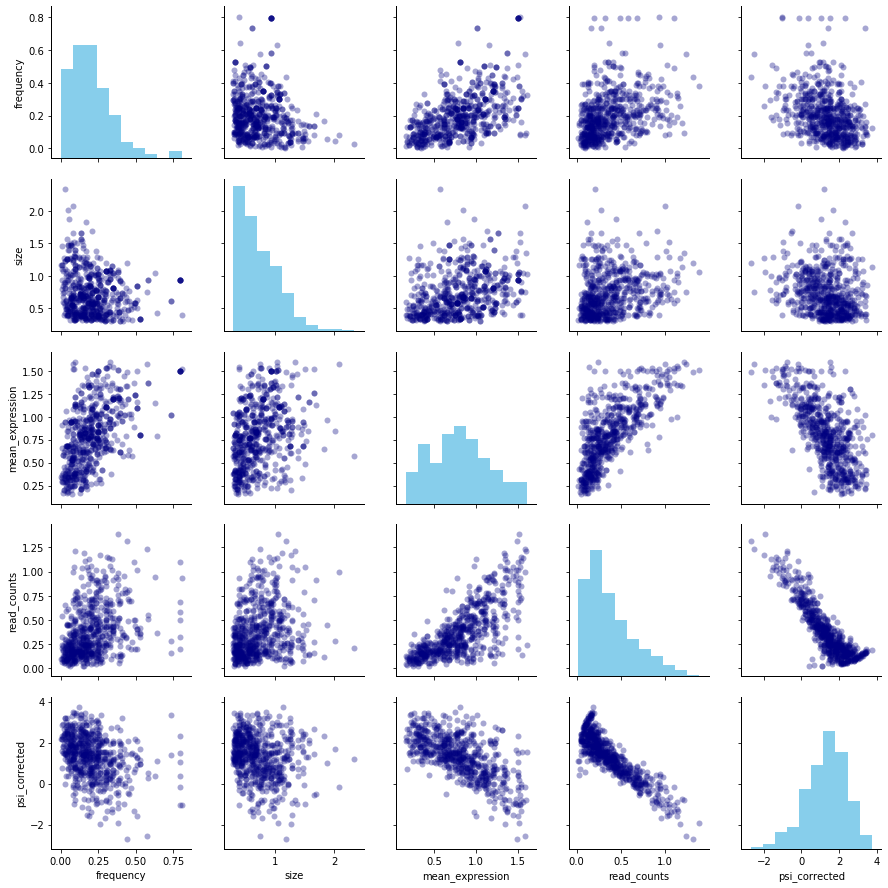

In [111]:
figsize(6, 6)
plt.figure()
g = sns.PairGrid(burst_psi_selected[['frequency', 'size', 'mean_expression', 'read_counts', 'psi_corrected']])
g.map_upper(plt.scatter,color='navy', alpha=0.35, linewidth=0)
g.map_lower(plt.scatter, color='navy', alpha=0.35, linewidth=0)
g.map_diag(plt.hist, color='skyblue')
plt.savefig('plots_review/figure1/kinetics/pairplot_mrna_n_reads.pdf', bbox_inches='tight', transparent=True)
plt.savefig('plots_review/figure1/kinetics/pairplot_mrna_n_reads.png', dpi=300, bbox_inches='tight', transparent=True)

In [115]:
def get_r2_score(X, target, metric='r2'):
    LR = LinearRegression()
    LR.fit(X, target)
    
    if metric == 'r2':
        r2 = r2_score(target, LR.predict(X))
        return r2
    
    elif metric == 'pearsonr':
        r = pearsonr(target, LR.predict(X))[0]
        return r
    
    else:
        mse = mean_squared_error(target, LR.predict(X))
        return mse



In [116]:
# r2 = []
# r2.append(get_r2_score(burst_psi_selected[['frequency']], burst_psi_selected['psi_corrected'], metric='pearsonr'))
# r2.append(get_r2_score(burst_psi_selected[['size']], burst_psi_selected['psi_corrected'], metric='pearsonr'))
# r2.append(get_r2_score(burst_psi_selected[['frequency', 'size']], burst_psi_selected['psi_corrected'], metric='pearsonr'))

# r2.append(get_r2_score(burst_psi_selected[['mean_expression']], burst_psi_selected['psi_corrected'], metric='pearsonr'))
# r2.append(get_r2_score(burst_psi_selected[['mean_expression', 'frequency']], burst_psi_selected['psi_corrected'], metric='pearsonr'))
# r2.append(get_r2_score(burst_psi_selected[['mean_expression', 'size']], burst_psi_selected['psi_corrected'], metric='pearsonr'))
# r2.append(get_r2_score(burst_psi_selected[['mean_expression', 'frequency', 'size']], burst_psi_selected['psi_corrected'], metric='pearsonr'))


# poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
# X = poly.fit_transform(burst_psi_selected[['frequency', 'size', 'mean_expression']])
# r2.append(get_r2_score(X, burst_psi_selected['psi_corrected'], metric='pearsonr'))

# # poly = PolynomialFeatures(2, interaction_only=False,include_bias = False)
# # X = poly.fit_transform(burst_psi_selected[['frequency', 'size', 'mean_expression']])
# # r2.append(get_r2_score(X, burst_psi_selected['psi_corrected']))

# poly = PolynomialFeatures(3, interaction_only=True,include_bias = False)
# X = poly.fit_transform(burst_psi_selected[['frequency', 'size', 'mean_expression']])
# r2.append(get_r2_score(X, burst_psi_selected['psi_corrected'], metric='pearsonr'))

# # poly = PolynomialFeatures(3, interaction_only=False,include_bias = False)
# # X = poly.fit_transform(burst_psi_selected[['frequency', 'size', 'mean_expression']])
# # r2.append(get_r2_score(X, burst_psi_selected['psi_corrected']))

In [117]:
# figsize(12, 6)

# fig = plt.figure()
# ax  = plt.subplot(1,1,1)


# ax.spines["right"].set_visible(False)
# ax.spines["top"].set_visible(False)
# ax.tick_params(labelsize=28, length=5)
# # plt.title('Recall curves, ' + dset_name, fontsize=28)
# # plt.xlabel('-log10 p-value', fontsize=28)
# # plt.ylabel('Recall', fontsize=28)
# #     #plt.legend(frameon=False, fontsize=28)
# plt.xticks([1, 2, 3, 4, 5], ['1', '2', '3', '4', '5'])

# ax.bar(range(len(r2)), r2)

# for i, v in enumerate(r2):
#     ax.text(i + -.4, v + 0.01, str(round(v, 3)), fontsize=18)


# # plt.xticks([0, 1, 2], ['frequency', 'size', 'expression'], fontsize=20, rotation='vertical')    
# # plt.ylabel('regression coefficient')
# plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], 
#            ['frequency', 'size', 'freq, size', 'expression', 'freq, exp', 'size, exp', 'freq, size, exp',
#            'polynomial 2', 'polynomial 3'], 
#            fontsize=28, rotation='vertical')    
# plt.ylabel('Pearson $r$', fontsize=28)

In [ ]:
r2 = []
names = []
r2.append(get_r2_score(burst_psi_selected[['frequency']], burst_psi_selected['psi_corrected']))
names.append('freq')
r2.append(get_r2_score(burst_psi_selected[['size']], burst_psi_selected['psi_corrected']))
names.append('size')
r2.append(get_r2_score(burst_psi_selected[['psi_mean']], burst_psi_selected['psi_corrected']))
names.append('psi_mean')
r2.append(get_r2_score(burst_psi_selected[['frequency', 'size']], burst_psi_selected['psi_corrected']))
names.append('freq + size')

poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['frequency', 'size']])
r2.append(get_r2_score(np.array([y[2] for y in X]).reshape(-1, 1) , burst_psi_selected['psi_corrected']))
names.append('freq*size')

# poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
# X = poly.fit_transform(burst_psi_selected[['frequency', 'size']])
# r2.append(get_r2_score(X , burst_psi_selected['psi_corrected']))
# names.append('freq+size+freq*size')

poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['frequency', 'mean_expression']])
r2.append(get_r2_score(np.array([y[2] for y in X]).reshape(-1, 1) , burst_psi_selected['psi_corrected']))
names.append('freq*exp')


poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['size', 'mean_expression']])
r2.append(get_r2_score(np.array([y[2] for y in X]).reshape(-1, 1) , burst_psi_selected['psi_corrected']))
names.append('size*exp')

poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['psi_mean', 'mean_expression']])
r2.append(get_r2_score(np.array([y[2] for y in X]).reshape(-1, 1) , burst_psi_selected['psi_corrected']))
names.append('psi*exp')

poly = PolynomialFeatures(3, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['frequency', 'size', 'mean_expression']])
r2.append(get_r2_score(np.array([y[-1] for y in X]).reshape(-1, 1), burst_psi_selected['psi_corrected']))
names.append('size*freq*exp')


r2.append(get_r2_score(burst_psi_selected[['mean_expression']], burst_psi_selected['psi_corrected']))
names.append('exp')

r2.append(get_r2_score(burst_psi_selected[['mean_expression', 'frequency']], burst_psi_selected['psi_corrected']))
names.append('exp + freq')



r2.append(get_r2_score(burst_psi_selected[['mean_expression', 'size']], burst_psi_selected['psi_corrected']))
names.append('exp + size')


r2.append(get_r2_score(burst_psi_selected[['mean_expression', 'frequency', 'size']], burst_psi_selected['psi_corrected']))
names.append('exp + freq + size')

r2.append(get_r2_score(burst_psi_selected[['mean_expression', 'psi_mean']], burst_psi_selected['psi_corrected']))
names.append('exp + psi')

r2.append(get_r2_score(burst_psi_selected[['read_counts']], burst_psi_selected['psi_corrected']))
names.append('read')

r2.append(get_r2_score(burst_psi_selected[['mean_expression', 'read_counts']], burst_psi_selected['psi_corrected']))
names.append('exp + read')



r2.append(get_r2_score(burst_psi_selected[['mean_expression', 'frequency', 'size', 'psi_mean']], burst_psi_selected['psi_corrected']))
names.append('exp + freq + size + psi')

poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['frequency', 'size', 'mean_expression', 'psi_mean']])
r2.append(get_r2_score(X, burst_psi_selected['psi_corrected']))
names.append('all interactions')


# poly = PolynomialFeatures(3, interaction_only=True,include_bias = False)
# X = poly.fit_transform(burst_psi_selected[['frequency', 'size', 'mean_expression']])
# r2.append(get_r2_score(X, burst_psi_selected['psi_corrected']))


# poly = PolynomialFeatures(3, interaction_only=True,include_bias = False)
# X = poly.fit_transform(burst_psi_selected[['frequency', 'size', 'mean_expression']])
# r2.append(get_r2_score(np.array([y[-1] for y in X]).reshape(-1, 1), burst_psi_selected['psi_corrected']))


In [ ]:
figsize(14, 6)

fig = plt.figure()
ax  = plt.subplot(1,1,1)


ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=28, length=5)
# plt.title('Recall curves, ' + dset_name, fontsize=28)
# plt.xlabel('-log10 p-value', fontsize=28)
# plt.ylabel('Recall', fontsize=28)
#     #plt.legend(frameon=False, fontsize=28)
# plt.xticks([1, 2, 3, 4, 5], ['1', '2', '3', '4', '5'])

ax.bar(range(len(r2)), r2)

for i, v in enumerate(r2):
    ax.text(i + -.4, v + 0.01, str(round(v, 3)), fontsize=18)


# plt.xticks([0, 1, 2], ['frequency', 'size', 'expression'], fontsize=20, rotation='vertical')    
# plt.ylabel('regression coefficient')
plt.xticks(range(len(names)), names, 
           fontsize=28, rotation='vertical')    
plt.ylabel('Regression $R^2$', fontsize=28)

In [131]:
r2 = []
names = []
r2.append(get_r2_score(burst_psi_selected[['frequency']], burst_psi_selected['psi_corrected']))
names.append('freq')
r2.append(get_r2_score(burst_psi_selected[['size']], burst_psi_selected['psi_corrected']))
names.append('size')
r2.append(get_r2_score(burst_psi_selected[['psi_mean']], burst_psi_selected['psi_corrected']))
names.append('psi')
r2.append(get_r2_score(burst_psi_selected[['frequency', 'size']], burst_psi_selected['psi_corrected']))
names.append('freq + size')
r2.append(get_r2_score(burst_psi_selected[['frequency', 'size', 'psi_mean']], burst_psi_selected['psi_corrected']))
names.append('freq + size + psi')

poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['frequency', 'size']])
r2.append(get_r2_score(np.array([y[2] for y in X]).reshape(-1, 1) , burst_psi_selected['psi_corrected']))
names.append('freq*size')

poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['frequency', 'mean_expression']])
r2.append(get_r2_score(np.array([y[2] for y in X]).reshape(-1, 1) , burst_psi_selected['psi_corrected']))
names.append('freq*exp')

poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['size', 'mean_expression']])
r2.append(get_r2_score(np.array([y[2] for y in X]).reshape(-1, 1) , burst_psi_selected['psi_corrected']))
names.append('size*exp')

poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['psi_mean', 'mean_expression']])
r2.append(get_r2_score(np.array([y[2] for y in X]).reshape(-1, 1) , burst_psi_selected['psi_corrected']))
names.append('psi*exp')

r2.append(get_r2_score(burst_psi_selected[['mean_expression']], burst_psi_selected['psi_corrected']))
names.append('exp')

r2.append(get_r2_score(burst_psi_selected[['mean_expression', 'frequency']], burst_psi_selected['psi_corrected']))
names.append('exp + freq')



r2.append(get_r2_score(burst_psi_selected[['mean_expression', 'size']], burst_psi_selected['psi_corrected']))
names.append('exp + size')


r2.append(get_r2_score(burst_psi_selected[['mean_expression', 'frequency', 'size']], burst_psi_selected['psi_corrected']))
names.append('exp + freq + size')

poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['frequency', 'size', 'mean_expression']])
r2.append(get_r2_score(X, burst_psi_selected['psi_corrected']))
names.append('polynomial freq, size, exp')

r2.append(get_r2_score(burst_psi_selected[['mean_expression', 'psi_mean']], burst_psi_selected['psi_corrected']))
names.append('exp + psi')

r2.append(get_r2_score(burst_psi_selected[['mean_expression', 'frequency', 'size', 'psi_mean']], 
                       burst_psi_selected['psi_corrected']))
names.append('exp + freq + size + psi')

poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['frequency', 'size', 'mean_expression', 'psi_mean']])
r2.append(get_r2_score(X, burst_psi_selected['psi_corrected']))
names.append('all interactions')


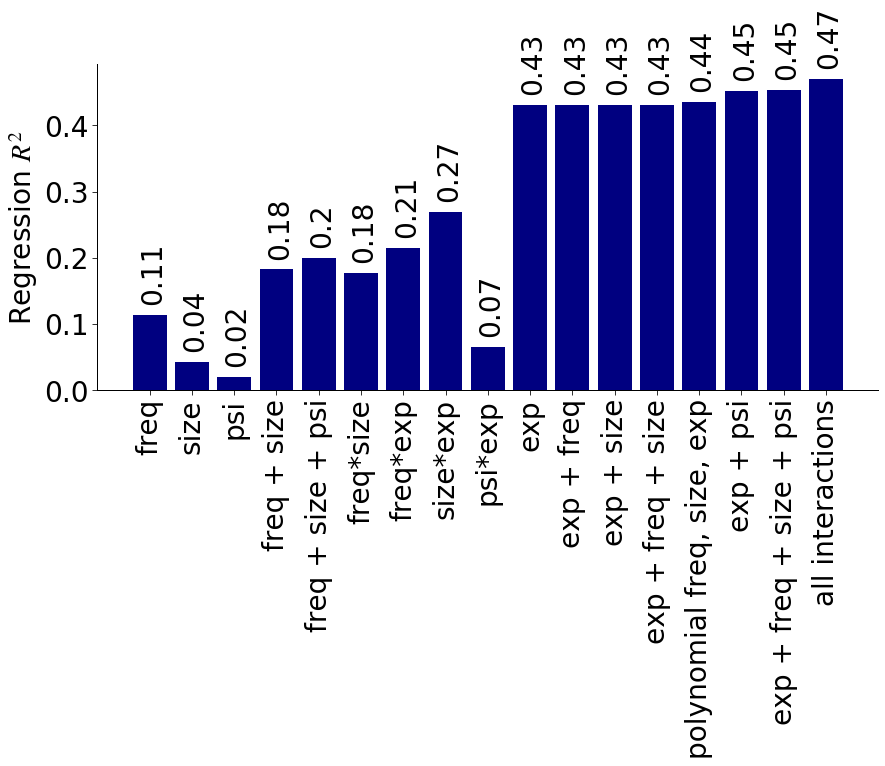

In [135]:
figsize(14, 6)

fig = plt.figure()
ax  = plt.subplot(1,1,1)


ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=28, length=5)

ax.bar(range(len(r2)), r2, color='navy')

for i, v in enumerate(r2):
    ax.text(i + -.25, v + 0.025, str(round(v, 2)), fontsize=28, rotation='vertical')


# plt.xticks([0, 1, 2], ['frequency', 'size', 'expression'], fontsize=20, rotation='vertical')    
# plt.ylabel('regression coefficient')
plt.xticks(range(len(names)), names, 
           fontsize=28, rotation='vertical')    
plt.ylabel('Regression $R^2$', fontsize=28)

plt.savefig('plots_review/figure1/kinetics/regression_mrna.pdf', bbox_inches='tight', transparent=True)
plt.savefig('plots_review/figure1/kinetics/regression_mrna.png', dpi=300, bbox_inches='tight', transparent=True)

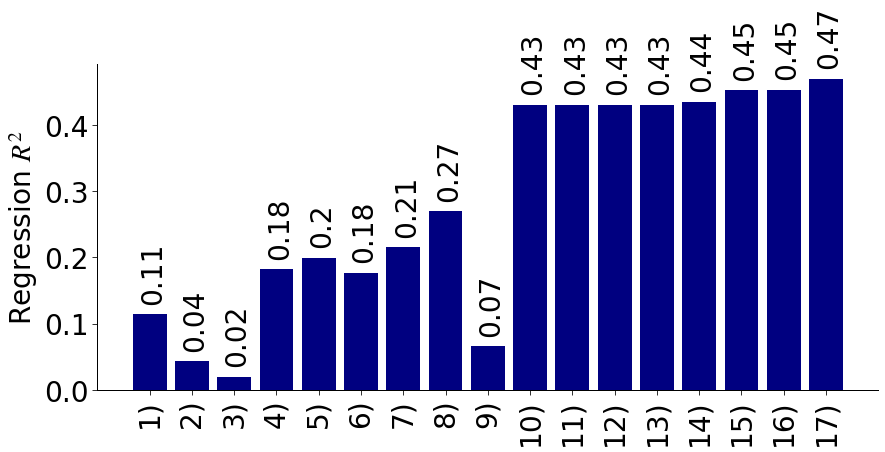

In [136]:
figsize(14, 6)

fig = plt.figure()
ax  = plt.subplot(1,1,1)


ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=28, length=5)

ax.bar(range(len(r2)), r2, color='navy')

for i, v in enumerate(r2):
    ax.text(i + -.25, v + 0.025, str(round(v, 2)), fontsize=28, rotation='vertical')


# plt.xticks([0, 1, 2], ['frequency', 'size', 'expression'], fontsize=20, rotation='vertical')    
# plt.ylabel('regression coefficient')
plt.xticks(range(len(names)), [str(x+1) + ')' for x in range(len(names))], 
           fontsize=28, rotation='vertical')    
plt.ylabel('Regression $R^2$', fontsize=28)

plt.savefig('plots_review/figure1/kinetics/regression_mrna_labels.pdf', bbox_inches='tight', transparent=True)
plt.savefig('plots_review/figure1/kinetics/regression_mrna_labels.png', dpi=300, bbox_inches='tight', transparent=True)

In [137]:
r2 = []
names = []
r2.append(get_r2_score(burst_psi_selected[['frequency']], burst_psi_selected['psi_corrected']))
names.append('freq')
r2.append(get_r2_score(burst_psi_selected[['size']], burst_psi_selected['psi_corrected']))
names.append('size')
r2.append(get_r2_score(burst_psi_selected[['psi_mean']], burst_psi_selected['psi_corrected']))
names.append('psi')
r2.append(get_r2_score(burst_psi_selected[['frequency', 'size']], burst_psi_selected['psi_corrected']))
names.append('freq + size')
r2.append(get_r2_score(burst_psi_selected[['frequency', 'size', 'psi_mean']], burst_psi_selected['psi_corrected']))
names.append('freq + size + psi')

poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['frequency', 'size']])
r2.append(get_r2_score(np.array([y[2] for y in X]).reshape(-1, 1) , burst_psi_selected['psi_corrected']))
names.append('freq*size')

poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['frequency', 'read_counts']])
r2.append(get_r2_score(np.array([y[2] for y in X]).reshape(-1, 1) , burst_psi_selected['psi_corrected']))
names.append('freq*exp')

poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['size', 'read_counts']])
r2.append(get_r2_score(np.array([y[2] for y in X]).reshape(-1, 1) , burst_psi_selected['psi_corrected']))
names.append('size*exp')

poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['psi_mean', 'read_counts']])
r2.append(get_r2_score(np.array([y[2] for y in X]).reshape(-1, 1) , burst_psi_selected['psi_corrected']))
names.append('psi*exp')

r2.append(get_r2_score(burst_psi_selected[['read_counts']], burst_psi_selected['psi_corrected']))
names.append('exp')

r2.append(get_r2_score(burst_psi_selected[['read_counts', 'frequency']], burst_psi_selected['psi_corrected']))
names.append('exp + freq')



r2.append(get_r2_score(burst_psi_selected[['read_counts', 'size']], burst_psi_selected['psi_corrected']))
names.append('exp + size')


r2.append(get_r2_score(burst_psi_selected[['read_counts', 'frequency', 'size']], burst_psi_selected['psi_corrected']))
names.append('exp + freq + size')

poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['frequency', 'size', 'read_counts']])
r2.append(get_r2_score(X, burst_psi_selected['psi_corrected']))
names.append('polynomial freq, size, exp')

r2.append(get_r2_score(burst_psi_selected[['read_counts', 'psi_mean']], burst_psi_selected['psi_corrected']))
names.append('exp + psi')

r2.append(get_r2_score(burst_psi_selected[['read_counts', 'frequency', 'size', 'psi_mean']], 
                       burst_psi_selected['psi_corrected']))
names.append('exp + freq + size + psi')

poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['frequency', 'size', 'read_counts', 'psi_mean']])
r2.append(get_r2_score(X, burst_psi_selected['psi_corrected']))
names.append('all interactions')


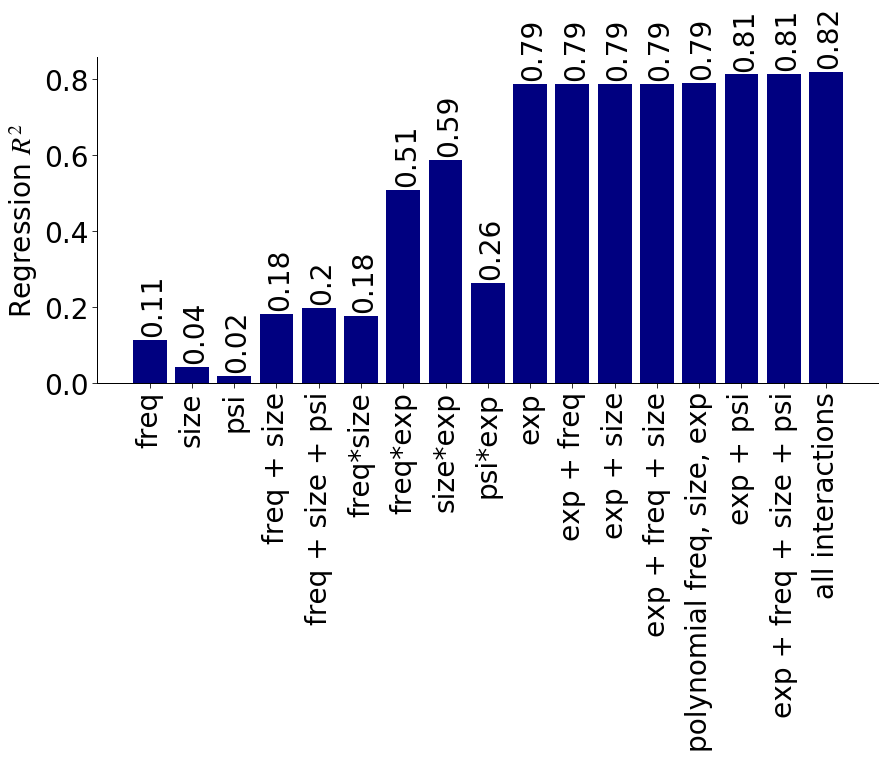

In [138]:
figsize(14, 6)

fig = plt.figure()
ax  = plt.subplot(1,1,1)


ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=28, length=5)

ax.bar(range(len(r2)), r2, color='navy')

for i, v in enumerate(r2):
    ax.text(i + -.25, v + 0.025, str(round(v, 2)), fontsize=28, rotation='vertical')


# plt.xticks([0, 1, 2], ['frequency', 'size', 'expression'], fontsize=20, rotation='vertical')    
# plt.ylabel('regression coefficient')
plt.xticks(range(len(names)), names, 
           fontsize=28, rotation='vertical')    
plt.ylabel('Regression $R^2$', fontsize=28)

plt.savefig('plots_review/figure1/kinetics/regression_read.pdf', bbox_inches='tight', transparent=True)
plt.savefig('plots_review/figure1/kinetics/regression_read.png', dpi=300, bbox_inches='tight', transparent=True)

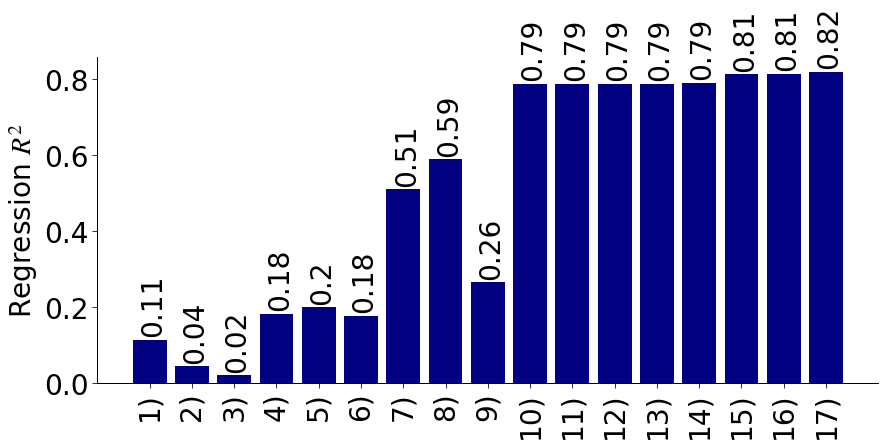

In [139]:
figsize(14, 6)

fig = plt.figure()
ax  = plt.subplot(1,1,1)


ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=28, length=5)

ax.bar(range(len(r2)), r2, color='navy')

for i, v in enumerate(r2):
    ax.text(i + -.25, v + 0.025, str(round(v, 2)), fontsize=28, rotation='vertical')


# plt.xticks([0, 1, 2], ['frequency', 'size', 'expression'], fontsize=20, rotation='vertical')    
# plt.ylabel('regression coefficient')
plt.xticks(range(len(names)), [str(x+1) + ')' for x in range(len(names))], 
           fontsize=28, rotation='vertical')    
plt.ylabel('Regression $R^2$', fontsize=28)

plt.savefig('plots_review/figure1/kinetics/regression_read_labels.pdf', bbox_inches='tight', transparent=True)
plt.savefig('plots_review/figure1/kinetics/regression_read_labels.png', dpi=300, bbox_inches='tight', transparent=True)

In [210]:
r2 = []
names = []
r2.append(get_r2_score(burst_psi_selected[['psi_mean']], burst_psi_selected['psi_corrected']))
names.append('psi')
r2.append(get_r2_score(burst_psi_selected[['size']], burst_psi_selected['psi_corrected']))
names.append('size')
r2.append(get_r2_score(burst_psi_selected[['frequency']], burst_psi_selected['psi_corrected']))
names.append('freq')
# r2.append(get_r2_score(burst_psi_selected[['frequency', 'size', 'psi_mean']], burst_psi_selected['psi_corrected']))
# names.append('freq + size + psi')

poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['frequency', 'size', 'psi_mean']])
r2.append(get_r2_score(X, burst_psi_selected['psi_corrected']))
names.append('poly freq*size*psi')

poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['psi_mean', 'read_counts']])
r2.append(get_r2_score(np.array([y[2] for y in X]).reshape(-1, 1) , burst_psi_selected['psi_corrected']))
names.append('psi*exp')

poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['size', 'read_counts']])
r2.append(get_r2_score(np.array([y[2] for y in X]).reshape(-1, 1) , burst_psi_selected['psi_corrected']))
names.append('size*exp')

poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['frequency', 'read_counts']])
r2.append(get_r2_score(np.array([y[2] for y in X]).reshape(-1, 1) , burst_psi_selected['psi_corrected']))
names.append('freq*exp')





r2.append(get_r2_score(burst_psi_selected[['read_counts']], burst_psi_selected['psi_corrected']))
names.append('exp')

# r2.append(get_r2_score(burst_psi_selected[['read_counts', 'frequency', 'size']], burst_psi_selected['psi_corrected']))
# names.append('exp + freq + size')

poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['frequency', 'size', 'read_counts']])
r2.append(get_r2_score(X, burst_psi_selected['psi_corrected']))
names.append('poly exp freq size')

r2.append(get_r2_score(burst_psi_selected[['read_counts', 'psi_mean']], burst_psi_selected['psi_corrected']))
names.append('exp + psi')

poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = poly.fit_transform(burst_psi_selected[['frequency', 'size', 'read_counts', 'psi_mean']])
r2.append(get_r2_score(X, burst_psi_selected['psi_corrected']))
names.append('all interactions')


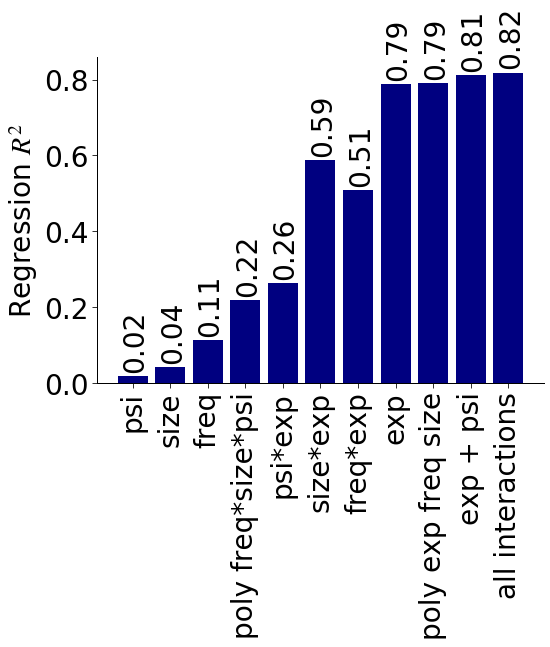

In [218]:
figsize(8, 6)

fig = plt.figure()
ax  = plt.subplot(1,1,1)


ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=28, length=5)

ax.bar(range(len(r2)), r2, color='navy')

for i, v in enumerate(r2):
    ax.text(i + -.3, v + 0.025, str(round(v, 2)), fontsize=28, rotation='vertical')


# plt.xticks([0, 1, 2], ['frequency', 'size', 'expression'], fontsize=20, rotation='vertical')    
# plt.ylabel('regression coefficient')
plt.xticks(range(len(names)), names, 
           fontsize=28, rotation='vertical')    
plt.ylabel('Regression $R^2$', fontsize=28)

plt.savefig('plots_review/figure1/kinetics/regression_read_short.pdf', bbox_inches='tight', transparent=True)
plt.savefig('plots_review/figure1/kinetics/regression_read_short.png', dpi=300, bbox_inches='tight', transparent=True)

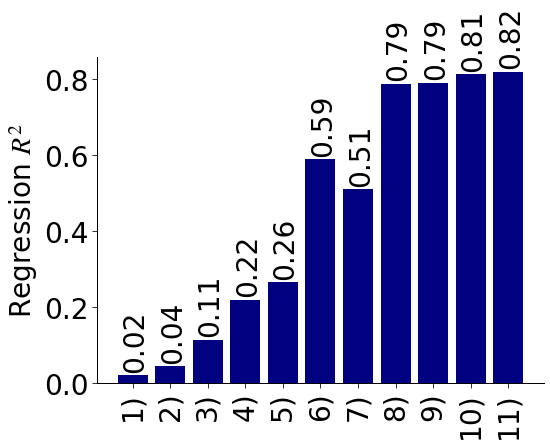

In [217]:
figsize(8, 6)

fig = plt.figure()
ax  = plt.subplot(1,1,1)


ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=28, length=5)

ax.bar(range(len(r2)), r2, color='navy')

for i, v in enumerate(r2):
    ax.text(i + -.3, v + 0.025, str(round(v, 2)), fontsize=28, rotation='vertical')


# plt.xticks([0, 1, 2], ['frequency', 'size', 'expression'], fontsize=20, rotation='vertical')    
# plt.ylabel('regression coefficient')
plt.xticks(range(len(names)), [str(x+1) + ')' for x in range(len(names))], 
           fontsize=28, rotation='vertical')   
plt.ylabel('Regression $R^2$', fontsize=28)

plt.savefig('plots_review/figure1/kinetics/regression_read_short_labels.pdf', bbox_inches='tight', transparent=True)
plt.savefig('plots_review/figure1/kinetics/regression_read_short_labels.png', dpi=300, bbox_inches='tight', transparent=True)

In [143]:
def test_burst(PSI_tab, mrna_counts, mrna_per_event, read_counts, subpop, kinetic_table,  min_unimodal = 0.2):

    int_genes, int_exons = spu.get_int_events(PSI_tab[subpop], mrna_counts[subpop], min_unimodal = min_unimodal)

    size_list = []
    frequency_list = []
    psi_binary = []
    exon_lista = []
    psi_std = []
    psi_mean = []
    for i in int_exons:
        if i.split('_')[0] in kinetic_table.index:
            exon_lista.append(i)
            size_list.append(kinetic_table.loc[i.split('_')[0], ['C57_size', 'CAST_size']].mean())
            frequency_list.append(kinetic_table.loc[i.split('_')[0], ['C57_frequency', 'CAST_frequency']].mean())
            psi_binary.append((np.abs(0.5 - PSI_tab[subpop].loc[i]) >= 0.45).sum() / np.sum(~PSI_tab[subpop].loc[i].isna()))
            psi_std.append(PSI_tab[subpop].loc[i].std())
            psi_mean.append(PSI_tab[subpop].loc[i].mean())
        

    burst_psi = pd.DataFrame()
    burst_psi['exon'] = exon_lista
    burst_psi['frequency'] = frequency_list
    burst_psi['size'] = size_list
    burst_psi['psi_std'] = psi_std
    burst_psi['psi_mean'] = np.abs(0.5 - np.array(psi_mean))
    burst_psi['psi_binary'] = psi_binary
    burst_psi = burst_psi.set_index('exon')

    burst_expression =  mrna_per_event.loc[burst_psi.index, subpop].mean(axis=1)
    reads =  read_counts.loc[burst_psi.index, subpop].mean(axis=1)
    burst_psi['mean_expression'] = np.log10(burst_expression+1)
    burst_psi['read_counts'] = np.log10(reads+1)
    
    low_exp = burst_expression.index[burst_expression <= burst_expression.quantile(0.25)]
    med_exp = burst_expression.index[(burst_expression > burst_expression.quantile(0.25)) & ((burst_expression <= burst_expression.quantile(0.5)))]
    med_high_exp = burst_expression.index[(burst_expression > burst_expression.quantile(0.5)) & ((burst_expression <= burst_expression.quantile(0.75)))]
    high_exp = burst_expression.index[burst_expression > burst_expression.quantile(0.75)]
    
    freq_cor_bin = []
    freq_cor_std = []
    
    size_cor_bin = []
    size_cor_std = []
    
    freq_cor_bin.append(test_pearson(np.log10(burst_psi.loc[low_exp, 'frequency']+1), burst_psi.loc[low_exp, 'psi_binary']))
    freq_cor_bin.append(test_pearson(np.log10(burst_psi.loc[med_exp, 'frequency']+1), burst_psi.loc[med_exp, 'psi_binary']))
    freq_cor_bin.append(test_pearson(np.log10(burst_psi.loc[med_high_exp, 'frequency']+1), burst_psi.loc[med_high_exp, 'psi_binary']))
    freq_cor_bin.append(test_pearson(np.log10(burst_psi.loc[high_exp, 'frequency']+1), burst_psi.loc[high_exp, 'psi_binary']))
    
    freq_cor_std.append(test_pearson(np.log10(burst_psi.loc[low_exp, 'frequency']+1), burst_psi.loc[low_exp, 'psi_std']))
    freq_cor_std.append(test_pearson(np.log10(burst_psi.loc[med_exp, 'frequency']+1), burst_psi.loc[med_exp, 'psi_std']))
    freq_cor_std.append(test_pearson(np.log10(burst_psi.loc[med_high_exp, 'frequency']+1), burst_psi.loc[med_high_exp, 'psi_std']))
    freq_cor_std.append(test_pearson(np.log10(burst_psi.loc[high_exp, 'frequency']+1), burst_psi.loc[high_exp, 'psi_std']))
    
    size_cor_bin.append(test_pearson(np.log10(burst_psi.loc[low_exp, 'size']+1), burst_psi.loc[low_exp, 'psi_binary']))
    size_cor_bin.append(test_pearson(np.log10(burst_psi.loc[med_exp, 'size']+1), burst_psi.loc[med_exp, 'psi_binary']))
    size_cor_bin.append(test_pearson(np.log10(burst_psi.loc[med_high_exp, 'size']+1), burst_psi.loc[med_high_exp, 'psi_binary']))
    size_cor_bin.append(test_pearson(np.log10(burst_psi.loc[high_exp, 'size']+1), burst_psi.loc[high_exp, 'psi_binary']))
    
    size_cor_std.append(test_pearson(np.log10(burst_psi.loc[low_exp, 'size']+1), burst_psi.loc[low_exp, 'psi_std']))
    size_cor_std.append(test_pearson(np.log10(burst_psi.loc[med_exp, 'size']+1), burst_psi.loc[med_exp, 'psi_std']))
    size_cor_std.append(test_pearson(np.log10(burst_psi.loc[med_high_exp, 'size']+1), burst_psi.loc[med_high_exp, 'psi_std']))
    size_cor_std.append(test_pearson(np.log10(burst_psi.loc[high_exp, 'size']+1), burst_psi.loc[high_exp, 'psi_std']))
    
    return freq_cor_bin, freq_cor_std, size_cor_bin, size_cor_std, burst_psi, low_exp, med_exp, med_high_exp, high_exp


In [144]:
ES2i_kinetics = test_burst(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts,
                           list(chen_ES2i), kinetic_table,  min_unimodal = 0.2)


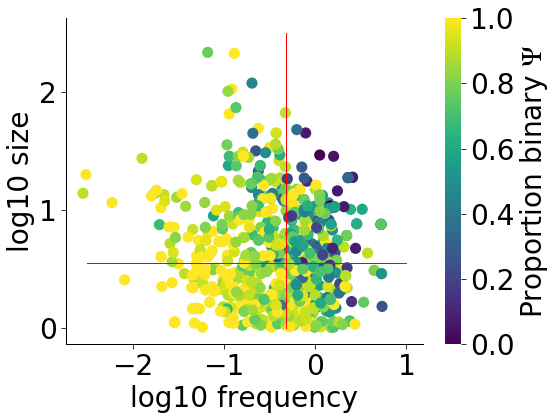

In [199]:
figsize(8, 6)
plt.figure()
ax = subplot(1,1,1)
burst_psi_ES2i = ES2i_kinetics[4]

sc = ax.scatter(np.log10(burst_psi_ES2i['frequency']), np.log10(burst_psi_ES2i['size']),
           c = burst_psi_ES2i['psi_binary'], cmap=cm.viridis, vmin=0, vmax=1,  s=125, edgecolors='none')
cb = plt.colorbar(sc)
cb.set_label('Proportion binary $\Psi$', size=28)
cb.ax.tick_params(labelsize=28, length=5)
cb.outline.set_visible(False)
freq_med = burst_psi_ES2i['frequency'].median()
size_med = burst_psi_ES2i['size'].median()
plt.plot([np.log10(freq_med), np.log10(freq_med)], [0, 2.5], c='red', linewidth=1)
plt.plot([-2.5, 1], [np.log10(size_med), np.log10(size_med)], c='red', linewidth=1)
plt.xlabel('log10 frequency', fontsize=28)
plt.ylabel('log10 size', fontsize=28)
ax.tick_params(labelsize=28, length=5)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
# plt.title('effect of burst kinetics in $\Psi$ binarity')
plt.savefig('plots_review/figure1/kinetics/freq_size.pdf', bbox_inches='tight', transparent=True)
plt.savefig('plots_review/figure1/kinetics/freq_size.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [219]:
pearsonr(np.log10(burst_psi_ES2i['frequency']), burst_psi_ES2i['psi_binary'])

(-0.4407888103881434, 4.680961482675222e-41)

In [220]:
pearsonr(np.log10(burst_psi_ES2i['size']), burst_psi_ES2i['psi_binary'])

(-0.2479887378884995, 3.504279305263235e-13)

In [221]:
def get_r2_score(X, target, samples = 0):
    
    if samples == 0:
        LR = LinearRegression()
        LR.fit(X, target)

        r2 = r2_score(target, LR.predict(X))
    
    else:
        r2_list = []
        for i in range(samples):
            train_size = round(len(X.index)*0.8)
            train_set = r.choice(X.index, train_size)
            test_set = [x for x in X.index if x not in train_set]
            
            LR = LinearRegression()
            LR.fit(X.loc[train_set], target.loc[train_set])
            
            r2_list.append(r2_score(target.loc[test_set], LR.predict(X.loc[test_set])))
        r2 = np.mean(r2_list)
    return r2

In [190]:
r2 = []
names = []
r2.append(get_r2_score(burst_psi_selected[['frequency']], burst_psi_selected['psi_corrected'], samples=50))
names.append('freq')
r2.append(get_r2_score(burst_psi_selected[['size']], burst_psi_selected['psi_corrected'], samples=50))
names.append('size')
r2.append(get_r2_score(burst_psi_selected[['psi_mean']], burst_psi_selected['psi_corrected'], samples=50))
names.append('psi')
r2.append(get_r2_score(burst_psi_selected[['frequency', 'size']], burst_psi_selected['psi_corrected'], samples=50))
names.append('freq + size')
r2.append(get_r2_score(burst_psi_selected[['frequency', 'size', 'psi_mean']], burst_psi_selected['psi_corrected'], samples=50))
names.append('freq + size + psi')

poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = pd.DataFrame(poly.fit_transform(burst_psi_selected[['frequency', 'size']]))
# X.columns = ['frequency', 'size']
X.index = burst_psi_selected.index
r2.append(get_r2_score(pd.DataFrame(X[2]) , burst_psi_selected['psi_corrected'], samples=50))
names.append('freq*size')

poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = pd.DataFrame(poly.fit_transform(burst_psi_selected[['frequency', 'read_counts']]))
# X.columns = ['frequency', 'read_counts']
X.index = burst_psi_selected.index
r2.append(get_r2_score(pd.DataFrame(X[2]) , burst_psi_selected['psi_corrected'], samples=50))
names.append('freq*exp')

poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = pd.DataFrame(poly.fit_transform(burst_psi_selected[['size', 'read_counts']]))
# X.columns =['size', 'read_counts']
X.index = burst_psi_selected.index
r2.append(get_r2_score(pd.DataFrame(X[2]) , burst_psi_selected['psi_corrected'], samples=50))
names.append('size*exp')

poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = pd.DataFrame(poly.fit_transform(burst_psi_selected[['psi_mean', 'read_counts']]))
# X.columns =['psi_mean', 'read_counts']
X.index = burst_psi_selected.index
r2.append(get_r2_score(pd.DataFrame(X[2]) , burst_psi_selected['psi_corrected'], samples=50))
names.append('psi*exp')

r2.append(get_r2_score(burst_psi_selected[['read_counts']], burst_psi_selected['psi_corrected'], samples=50))
names.append('exp')

r2.append(get_r2_score(burst_psi_selected[['read_counts', 'frequency']], burst_psi_selected['psi_corrected'], samples=50))
names.append('exp + freq')



r2.append(get_r2_score(burst_psi_selected[['read_counts', 'size']], burst_psi_selected['psi_corrected'], samples=50))
names.append('exp + size')


r2.append(get_r2_score(burst_psi_selected[['read_counts', 'frequency', 'size']], burst_psi_selected['psi_corrected'], samples=50))
names.append('exp + freq + size')

poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = pd.DataFrame(poly.fit_transform(burst_psi_selected[['frequency', 'size', 'read_counts']]))
# X.columns =['frequency', 'size', 'read_counts']
X.index = burst_psi_selected.index
r2.append(get_r2_score(X, burst_psi_selected['psi_corrected'], samples=50))
names.append('polynomial freq, size, exp')

r2.append(get_r2_score(burst_psi_selected[['read_counts', 'psi_mean']], burst_psi_selected['psi_corrected'], samples=30))
names.append('exp + psi')

r2.append(get_r2_score(burst_psi_selected[['read_counts', 'frequency', 'size', 'psi_mean']], 
                       burst_psi_selected['psi_corrected'], samples=50))
names.append('exp + freq + size + psi')

poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = pd.DataFrame(poly.fit_transform(burst_psi_selected[['frequency', 'size', 'read_counts', 'psi_mean']]))
# X.columns =['frequency', 'size', 'read_counts']
X.index = burst_psi_selected.index
r2.append(get_r2_score(X, burst_psi_selected['psi_corrected'], samples=50))
names.append('all interactions')


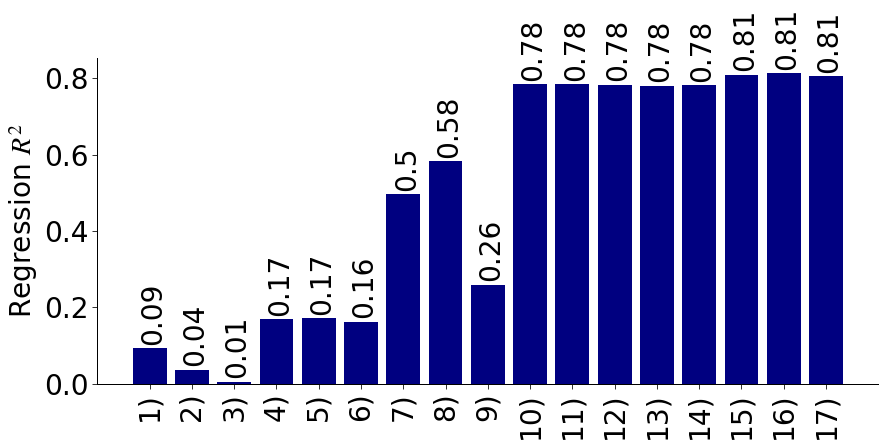

In [191]:
figsize(14, 6)

fig = plt.figure()
ax  = plt.subplot(1,1,1)


ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=28, length=5)

ax.bar(range(len(r2)), r2, color='navy')

for i, v in enumerate(r2):
    ax.text(i + -.25, v + 0.025, str(round(v, 2)), fontsize=28, rotation='vertical')


# plt.xticks([0, 1, 2], ['frequency', 'size', 'expression'], fontsize=20, rotation='vertical')    
# plt.ylabel('regression coefficient')
plt.xticks(range(len(names)), [str(x+1) + ')' for x in range(len(names))], 
           fontsize=28, rotation='vertical')    
plt.ylabel('Regression $R^2$', fontsize=28)

plt.savefig('plots_review/figure1/kinetics/regression_read_labels_train_test.pdf', 
            bbox_inches='tight', transparent=True)
plt.savefig('plots_review/figure1/kinetics/regression_read_labels_train_test.png', 
            dpi=300, bbox_inches='tight', transparent=True)

In [229]:
r2 = []
names = []
r2.append(get_r2_score(burst_psi_selected[['psi_mean']], burst_psi_selected['psi_corrected'], samples=100))
names.append('psi')
r2.append(get_r2_score(burst_psi_selected[['size']], burst_psi_selected['psi_corrected'], samples=100))
names.append('size')
r2.append(get_r2_score(burst_psi_selected[['frequency']], burst_psi_selected['psi_corrected'], samples=100))
names.append('freq')
# r2.append(get_r2_score(burst_psi_selected[['frequency', 'size', 'psi_mean']], burst_psi_selected['psi_corrected'], samples=100))
# names.append('freq + size + psi')


###########

# poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
# X = poly.fit_transform(burst_psi_selected[['frequency', 'size', 'psi_mean']])
# r2.append(get_r2_score(X, burst_psi_selected['psi_corrected'], samples=100))
# names.append('poly freq*size*psi')


poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = pd.DataFrame(poly.fit_transform(burst_psi_selected[['frequency', 'size', 'psi_mean']]))
X.index = burst_psi_selected.index
r2.append(get_r2_score(X , burst_psi_selected['psi_corrected'], samples=100))
names.append('poly freq*size*psi')

#######

# poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
# X = poly.fit_transform(burst_psi_selected[['psi_mean', 'read_counts']])
# r2.append(get_r2_score(np.array([y[2] for y in X]).reshape(-1, 1) , burst_psi_selected['psi_corrected'], samples=100))
# names.append('psi*exp')


poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = pd.DataFrame(poly.fit_transform(burst_psi_selected[['psi_mean', 'read_counts']]))
# X.columns =['psi_mean', 'read_counts']
X.index = burst_psi_selected.index
r2.append(get_r2_score(pd.DataFrame(X[2]) , burst_psi_selected['psi_corrected'], samples=100))
names.append('psi*exp')

######



# poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
# X = poly.fit_transform(burst_psi_selected[['size', 'read_counts']])
# r2.append(get_r2_score(np.array([y[2] for y in X]).reshape(-1, 1) , burst_psi_selected['psi_corrected'], samples=100))
# names.append('size*exp')

poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = pd.DataFrame(poly.fit_transform(burst_psi_selected[['size', 'read_counts']]))
# X.columns =['psi_mean', 'read_counts']
X.index = burst_psi_selected.index
r2.append(get_r2_score(pd.DataFrame(X[2]) , burst_psi_selected['psi_corrected'], samples=100))
names.append('size*exp')

######

# poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
# X = poly.fit_transform(burst_psi_selected[['frequency', 'read_counts']])
# r2.append(get_r2_score(np.array([y[2] for y in X]).reshape(-1, 1) , burst_psi_selected['psi_corrected'], samples=100))
# names.append('freq*exp')

poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = pd.DataFrame(poly.fit_transform(burst_psi_selected[['frequency', 'read_counts']]))
# X.columns =['psi_mean', 'read_counts']
X.index = burst_psi_selected.index
r2.append(get_r2_score(pd.DataFrame(X[2]) , burst_psi_selected['psi_corrected'], samples=100))
names.append('freq*exp')

#####


r2.append(get_r2_score(burst_psi_selected[['read_counts']], burst_psi_selected['psi_corrected'], samples=100))
names.append('exp')

# r2.append(get_r2_score(burst_psi_selected[['read_counts', 'frequency', 'size']], burst_psi_selected['psi_corrected'], samples=100))
# names.append('exp + freq + size')

poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = pd.DataFrame(poly.fit_transform(burst_psi_selected[['frequency', 'size', 'read_counts']]))
X.index = burst_psi_selected.index
r2.append(get_r2_score(X, burst_psi_selected['psi_corrected'], samples=100))
names.append('poly exp freq size')

r2.append(get_r2_score(burst_psi_selected[['read_counts', 'psi_mean']], burst_psi_selected['psi_corrected'], samples=100))
names.append('exp + psi')

poly = PolynomialFeatures(2, interaction_only=True,include_bias = False)
X = pd.DataFrame(poly.fit_transform(burst_psi_selected[['frequency', 'size', 'read_counts', 'psi_mean']]))
X.index = burst_psi_selected.index
r2.append(get_r2_score(X, burst_psi_selected['psi_corrected'], samples=100))
names.append('all interactions')


In [230]:
burst_psi_selected[['psi_mean']].shape

(619, 1)

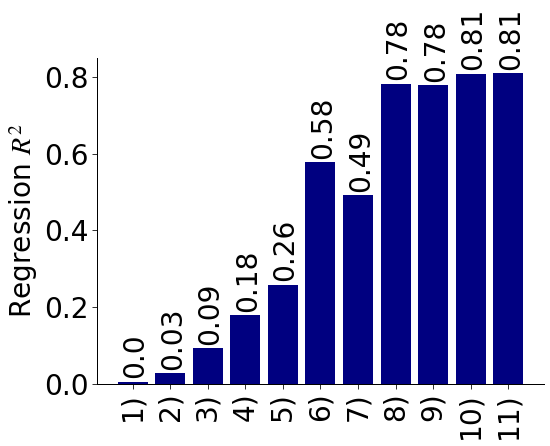

In [231]:
figsize(8, 6)

fig = plt.figure()
ax  = plt.subplot(1,1,1)


ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=28, length=5)

ax.bar(range(len(r2)), r2, color='navy')

for i, v in enumerate(r2):
    ax.text(i + -.3, v + 0.025, str(round(v, 2)), fontsize=28, rotation='vertical')


# plt.xticks([0, 1, 2], ['frequency', 'size', 'expression'], fontsize=20, rotation='vertical')    
# plt.ylabel('regression coefficient')
plt.xticks(range(len(names)), [str(x+1) + ')' for x in range(len(names))], 
           fontsize=28, rotation='vertical')   
plt.ylabel('Regression $R^2$', fontsize=28)

plt.savefig('plots_review/figure1/kinetics/regression_read_short_train_test_labels.pdf', 
            bbox_inches='tight', transparent=True)
plt.savefig('plots_review/figure1/kinetics/regression_read_short_train_test_labels.png', 
            dpi=300, bbox_inches='tight', transparent=True)